## İş Problemi

FLO satış ve pazarlama faaliyetleri için roadmap belirlemek istemektedir. Şirketin orta uzun vadeli plan yapabilmesi için var olan müşterilerin gelecekte şirkete sağlayacakları potansiyel değerin tahmin edilmesi gerekmektedir.

## Veri Seti Hikayesi

Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

# Görev 1: Veriyi Hazırlama
## Adım 1:
flo_data_20K.csv verisini okuyunuz.

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 500)

df_ = pd.read_csv('/Users/mericgenc/Desktop/Python - Data Science/Miuul Data Scientist Path/02 - CRM Analytics/05_flo_clv_prediction/dataset/flo_data_20k.csv')

df = df_.copy()

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


## Adım 2:
Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız.

Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız.

In [3]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

## Adım 3:
"order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayınız.

In [4]:
columns=["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"]

In [5]:
for col in columns:
    replace_with_thresholds(df, col)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


## Adım 4:
Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. Her bir müşterinin toplam alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.

In [7]:
df['total_order_num'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['total_order_value'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online']
df = df[~(df["customer_value_total"] == 0) | (df["order_num_total"] == 0)]
df.head()

KeyError: 'customer_value_total'

## Adım5:
Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [ ]:
date_cols = df.columns[df.columns.str.contains('date')]
df[date_cols] = df[date_cols].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# Görev 2: CLTV Veri Yapısının Oluşturulması
## Adım 1:
Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.

In [ ]:
from datetime import timedelta

analysis_date = df.last_order_date.max() + timedelta(days=2)
analysis_date

Timestamp('2021-06-01 00:00:00')

## Adım 2:
customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz.

Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.

In [ ]:
# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç

In [ ]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order_num,total_order_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [ ]:
clv = pd.DataFrame()

In [ ]:
clv['customer_id'] = df['master_id']
clv['recency_clv_weekly'] = ((df['last_order_date'] - df['first_order_date']).astype('timedelta64[D]')) / 7
clv['T_weekly'] = ((analysis_date - df['first_order_date']).astype('timedelta64[D]')) / 7
clv['frequency'] = df['total_order_num']
clv['monetary'] = df['total_order_value'] / df['total_order_num']
clv = clv[(clv['frequency'] > 1)]
clv.head()

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


# Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması
## Adım 1:
BG/NBD modelini fit ediniz.

• 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv dataframe'ine ekleyiniz.

• 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv dataframe'ine ekleyiniz.

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv['frequency'],
        clv['recency_clv_weekly'],
        clv['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [ ]:
clv['exp_sales_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4*3,
                                                        clv['frequency'],
                                                        clv['recency_clv_weekly'],
                                                        clv['T_weekly'])

clv.head()

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960


In [ ]:
clv['exp_sales_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4*6,
                                                        clv['frequency'],
                                                        clv['recency_clv_weekly'],
                                                        clv['T_weekly'])

clv.head()

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921


In [ ]:
clv.sort_values('exp_sales_3_month', ascending=False).head(10)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29.0000,165.2976,3.3740,6.7479
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25.0000,97.4396,3.1424,6.2848
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27.0000,141.3548,3.0013,6.0026
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.1429,111.8571,43.0000,157.1126,2.9780,5.9561
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,147.1429,49.0000,161.8467,2.8299,5.6598
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.7143,64.1429,29.0000,168.8810,2.7934,5.5869
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.5714,113.4286,40.0000,176.2000,2.7635,5.5270


In [ ]:
clv.sort_values('exp_sales_6_month', ascending=False).head(10)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29.0000,165.2976,3.3740,6.7479
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25.0000,97.4396,3.1424,6.2848
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27.0000,141.3548,3.0013,6.0026
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.1429,111.8571,43.0000,157.1126,2.9780,5.9561
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,147.1429,49.0000,161.8467,2.8299,5.6598
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.7143,64.1429,29.0000,168.8810,2.7934,5.5869
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.5714,113.4286,40.0000,176.2000,2.7635,5.5270


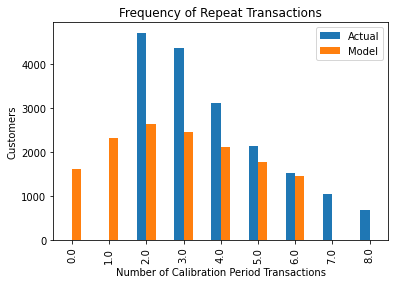

In [ ]:
plot_period_transactions(bgf)
plt.show()

## Adım 2:
Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv dataframe'ine ekleyiniz.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(clv['frequency'], clv['monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [ ]:
clv['exp_average_value'] = ggf.conditional_expected_average_profit(clv['frequency'], clv['monetary'])
clv.head()

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251


## Adım 3:
6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz.

• CLTV değeri en yüksek 20 kişiyi gözlemleyiniz.

In [ ]:
clv['clv'] = ggf.customer_lifetime_value(bgf,
                                   clv['frequency'],
                                   clv['recency_clv_weekly'],
                                   clv['T_weekly'],
                                   clv['monetary'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

clv.sort_values('clv', ascending=False).head(20)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


# Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması
## Adım 1:
6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz.

In [ ]:
clv['segment'] = pd.qcut(clv['clv'], 4, ['D','C','B','A'])
clv.head()

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [ ]:
clv.sort_values('clv', ascending=False).head(20)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127,A
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559,A
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280,A
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192,A
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997,A


In [ ]:
clv.groupby('segment').describe().T

segment                          D         C         B         A
recency_clv_weekly count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean   139.0002   92.6295   81.9884   67.4271
                   std     96.3682   64.5759   56.6193   52.1770
                   min      0.0000    0.0000    0.0000    0.0000
                   25%     68.9286   54.7143   48.8571   34.2857
                   50%    100.5714   77.8571   72.5714   62.4286
                   75%    200.0000  107.0000   98.5714   86.7143
                   max    432.5714  433.0000  415.5714  433.4286
T_weekly           count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean   162.1832  112.8183  100.3265   82.5497
                   std     95.9419   63.2186   54.9449   51.4363
                   min      3.5714    5.1429    1.1429    0.7143
                   25%     91.2857   78.2857   72.6071   51.7143
                   50%    118.1429   95.4286   89.5000   79.1429
                   75%    222.8571  119.0000  114.7143   98.2857
                   max    436.2857  434.7143  423.5714  437.1429
frequency          count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean     3.7688    4.4047    5.0927    6.6466
                   std      2.1405    2.9088    3.6930    6.0556
                   min      2.0000    2.0000    2.0000    2.0000
                   25%      2.0000    3.0000    3.0000    3.0000
                   50%      3.0000    4.0000    4.0000    5.0000
                   75%      4.0000    5.0000    6.0000    8.0000
                   max     18.0000   32.0000   50.0000   57.0000
monetary           count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean    93.1516  125.7885  160.6366  228.8311
                   std     30.5319   31.6013   40.6571   88.9551
                   min     22.4900   34.3156   50.0426   64.3645
                   25%     73.3200  104.6535  131.9187  170.4272
                   50%     89.4950  121.9900  156.8742  209.9575
                   75%    108.1200  141.2212  184.5035  264.2045
                   max    284.9850  342.8400  539.9850 1401.8000
exp_sales_3_month  count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean     0.4089    0.5254    0.6011    0.7730
                   std      0.1229    0.1281    0.1577    0.2966
                   min      0.1493    0.1620    0.1772    0.2118
                   25%      0.3260    0.4368    0.4877    0.5798
                   50%      0.4106    0.5097    0.5754    0.7115
                   75%      0.4834    0.5952    0.6864    0.8860
                   max      1.0498    1.5684    1.7822    4.6561
exp_sales_6_month  count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean     0.8178    1.0509    1.2022    1.5461
                   std      0.2459    0.2562    0.3155    0.5932
                   min      0.2985    0.3240    0.3545    0.4236
                   25%      0.6520    0.8737    0.9754    1.1597
                   50%      0.8212    1.0194    1.1508    1.4230
                   75%      0.9669    1.1905    1.3727    1.7720
                   max      2.0995    3.1369    3.5643    9.3123
exp_average_value  count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean    98.6911  132.2506  168.0006  238.0240
                   std     31.9677   33.8978   44.0946   94.5292
                   min     25.0830   34.7888   50.5971   64.9831
                   25%     77.3049  109.4667  136.3984  176.1322
                   50%     94.5639  128.4094  163.2849  218.2725
                   75%    114.4327  149.2677  194.3166  276.8883
                   max    306.5909  368.3901  578.9751 1449.0605
clv                count 4987.0000 4986.0000 4986.0000 4986.0000
                   mean    80.3405  138.3115  199.5328  362.3155
                   std     21.7257   15.3154   21.2056  158.4218
                   min     12.1080  112.2484  165.4692  240.0854
                   25%     65.0589 

A Grubu kendi içinde de parçalara ayrılabilir. A ile B arasındaki fark diğerlerinden çok daha fazla.

## Adım 2:
4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.

A Grubundaki müşteriler en değerli müşteriler olduğu için farklı hissettirilmesi gerekiyor. Bu yüzden onlara özel kampanyalar, Gold kart gibi ayrıcalıklı hissettirecek ürünler, özel davetler vs gibi etkinlikler planlanabilir.

D Grubu ise en az getirisi olan grup olduğu için nedeni araştırılmalıdır. Bu kitleyi daha fazla çekmek için indirimler yapılabilir. Kupon kazandırmalı veya belli bir dönemlik indirimler gibi müşteriyi satın almaya teşvik edecek kampanyalar yapılmalıdır.

# Bonus: Tüm Sürecin Fonksiyonlaştırılması

In [ ]:
def create_cltv_df(dataframe):

    # Veriyi Hazırlama
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe['total_order_num'] = dataframe['order_num_total_ever_online'] + dataframe['order_num_total_ever_offline']
    dataframe['total_order_value'] = dataframe['customer_value_total_ever_offline'] + dataframe['customer_value_total_ever_online']
    dataframe = dataframe[~(dataframe["total_order_value"] == 0) | (dataframe["total_order_num"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # CLTV veri yapısının oluşturulması
    analysis_date = df.last_order_date.max() + timedelta(days=2)
    clv = pd.DataFrame()
    clv["customer_id"] = dataframe["master_id"]
    clv["recency_clv_weekly"] = ((dataframe["last_order_date"] - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    clv["T_weekly"] = ((analysis_date - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    clv["frequency"] = dataframe["total_order_num"]
    clv["monetary_clv_avg"] = dataframe["total_order_value"] / dataframe["total_order_num"]
    clv = clv[(clv['frequency'] > 1)]

    # BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(clv['frequency'],
            clv['recency_clv_weekly'],
            clv['T_weekly'])
    clv["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               clv['frequency'],
                                               clv['recency_clv_weekly'],
                                               clv['T_weekly'])
    clv["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               clv['frequency'],
                                               clv['recency_clv_weekly'],
                                               clv['T_weekly'])

    # # Gamma-Gamma Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(clv['frequency'], clv['monetary_clv_avg'])
    clv["exp_average_value"] = ggf.conditional_expected_average_profit(clv['frequency'],
                                                                           clv['monetary_clv_avg'])

    # Cltv tahmini
    clv['clv'] = ggf.customer_lifetime_value(bgf,
                                   clv['frequency'],
                                   clv['recency_clv_weekly'],
                                   clv['T_weekly'],
                                   clv['monetary_clv_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

    # CLTV segmentleme
    clv['segment'] = pd.qcut(clv['clv'], 4, ['D','C','B','A'])

    return clv

In [ ]:
clv = create_cltv_df(df)
clv.head(10)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary_clv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,120.8571,132.2857,3.0000,66.9533,0.3836,0.7672,71.3481,57.4299,D
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,32.5714,64.8571,4.0000,93.9825,0.6521,1.3041,98.1334,134.2784,C
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,12.7143,54.5714,2.0000,81.8150,0.5198,1.0396,89.5702,97.7006,D
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,58.4286,70.7143,5.0000,210.9380,0.7078,1.4155,217.3009,322.7347,A
9,1143f032-440d-11ea-8b43-000d3a38a36f,61.7143,96.0000,2.0000,82.9800,0.3947,0.7894,90.8146,75.2224,D
